<a href="https://colab.research.google.com/github/anuskagithub/FraudDetection_UsingMobileTransactions/blob/main/Fraud_Detection_using_mobile_transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

#df = pd.read_csv('dataset.csv')
# See number of rows and columns


from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Replace the path below with your file path inside your Google Drive
file_path = '/content/drive/MyDrive/fraud_dataset/Copy_of_dataset.csv'

df = pd.read_csv(file_path)

print(df.shape)

print(df.head())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0      

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


isFraud
0    6354407
1       8213
Name: count, dtype: int64


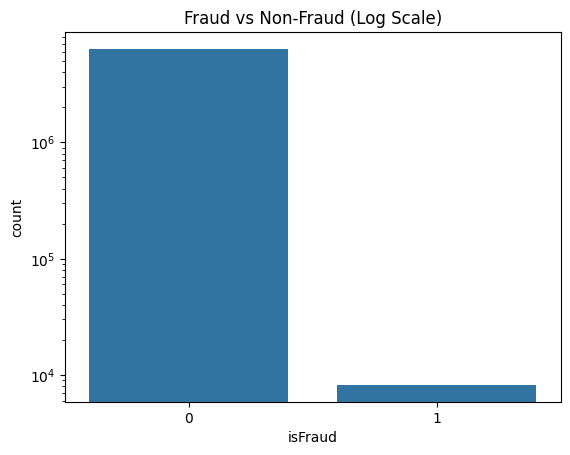

In [ ]:
print(df['isFraud'].value_counts())

sns.countplot(x='isFraud', data=df)
plt.yscale('log')
plt.title('Fraud vs Non-Fraud (Log Scale)')
plt.show()

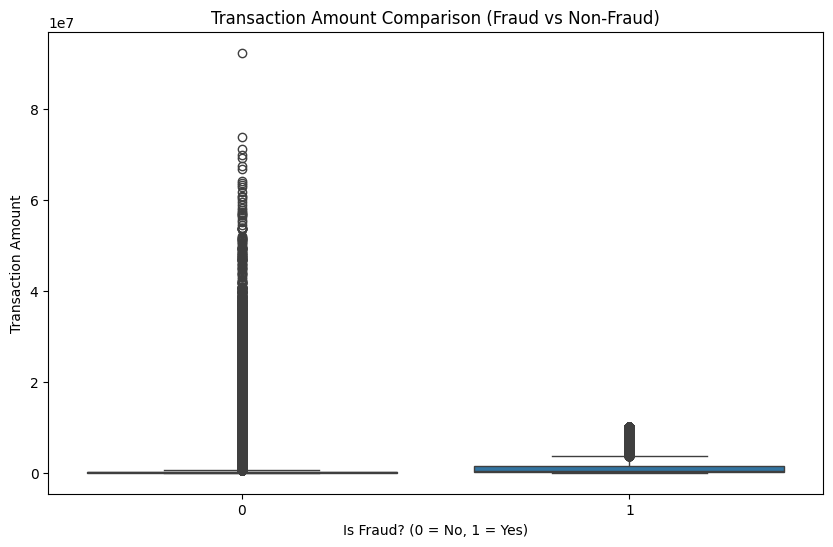

In [ ]:
plt.figure(figsize=(10,6))

sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Transaction Amount Comparison (Fraud vs Non-Fraud)')
plt.xlabel('Is Fraud? (0 = No, 1 = Yes)')
plt.ylabel('Transaction Amount')
plt.show()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


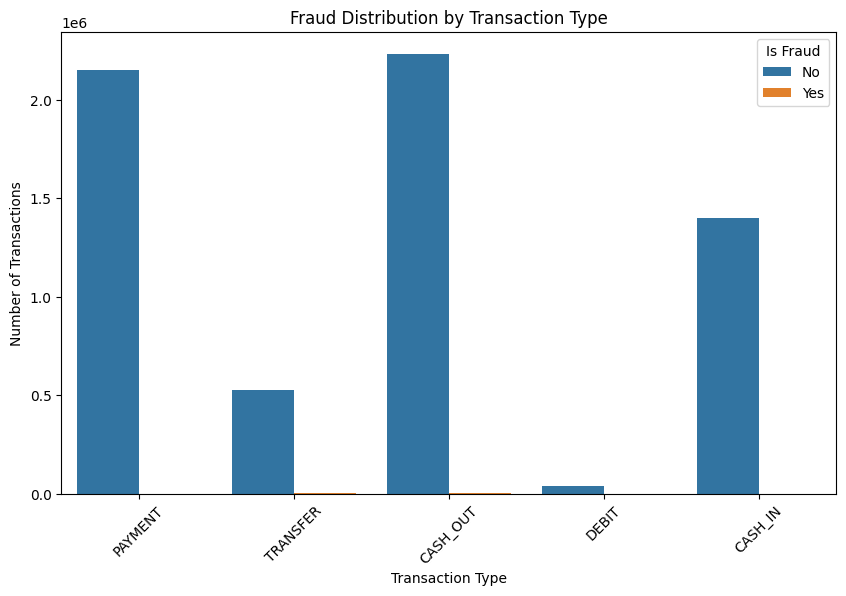

In [ ]:
print(df['type'].value_counts())

plt.figure(figsize=(10,6))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Fraud Distribution by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.legend(title='Is Fraud', labels=['No', 'Yes'])
plt.xticks(rotation=45)  # if the type names are long
plt.show()



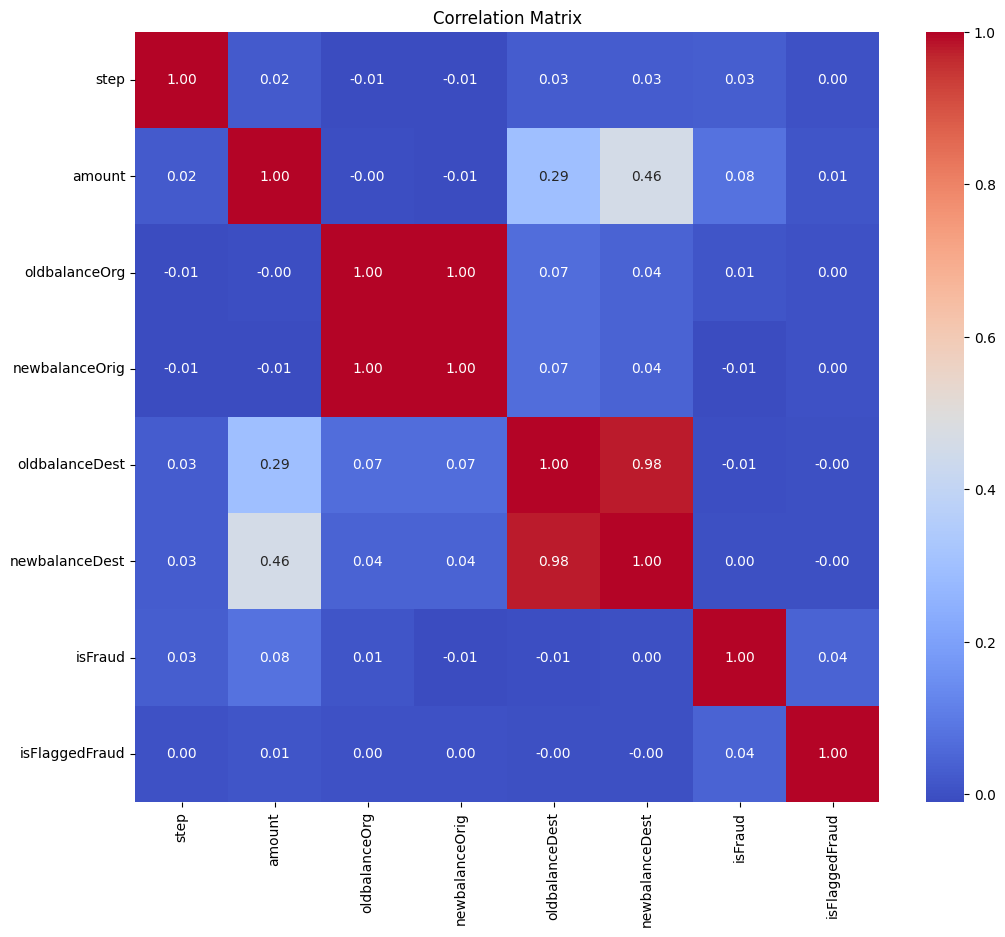

In [ ]:
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# 1. Encode categorical variables (if 'type' is the only categorical variable)
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

# 2. Split X and y
X = df.drop('isFraud', axis=1)  # Features
y = df['isFraud']  # Target variable

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Check for non-numeric columns (if any other categorical variables)
# Encode other categorical columns if needed or drop them
X_train = X_train.select_dtypes(exclude=['object'])  # Keep only numeric columns
X_test = X_test.select_dtypes(exclude=['object'])   # Keep only numeric columns

# 5. Scaling: Now apply scaling to only numeric columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [ ]:
#HANDLING CLASS IMBALANCING
from imblearn.over_sampling import SMOTE
import numpy as np

# Apply SMOTE to only the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Optional: Check new class distribution
print("Original class distribution:", np.bincount(y_train))
print("Resampled class distribution:", np.bincount(y_train_resampled))

# Train the model
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Original class distribution: [5083503    6593]
Resampled class distribution: [5083503 5083503]
Confusion Matrix:
 [[1233683   37221]
 [    159    1461]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99   1270904
           1       0.04      0.90      0.07      1620

    accuracy                           0.97   1272524
   macro avg       0.52      0.94      0.53   1272524
weighted avg       1.00      0.97      0.98   1272524


Accuracy Score: 0.9706253084421198


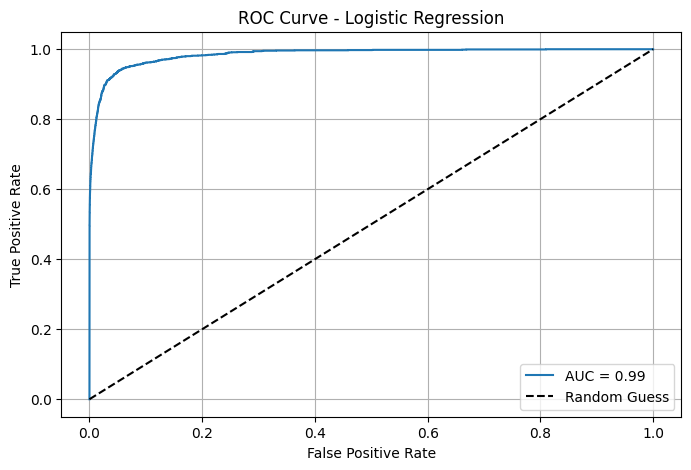

In [ ]:
#ROC-AUC Curve to visualize how well your model separates fraud vs non-fraud
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get prediction probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# ROC Curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_probs):.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid()
plt.show()


In [ ]:
#Using Random Forest

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate
rf_pred = rf_model.predict(X_test)

print("Random Forest Report:\n", classification_report(y_test, rf_pred))


Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    350013
           1       0.65      0.89      0.75       353

    accuracy                           1.00    350366
   macro avg       0.83      0.94      0.88    350366
weighted avg       1.00      1.00      1.00    350366



In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate
xgb_pred = xgb_model.predict(X_test)

print("XGBoost Report:\n", classification_report(y_test, xgb_pred))

XGBoost Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    350013
           1       0.23      0.96      0.37       353

    accuracy                           1.00    350366
   macro avg       0.62      0.98      0.69    350366
weighted avg       1.00      1.00      1.00    350366



In [ ]:
import pandas as pd

dataset_url = '/content/drive/MyDrive/fraud_dataset/Copy_of_dataset.csv'
df = pd.read_csv(dataset_url)

print(df.columns)
df.head()


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
!pip install dash==2.9.3 jupyter-dash scikit-learn pandas plotly

In [ ]:
# Step 1: Install dependencies (run once)
!pip install dash==2.9.3 jupyter-dash scikit-learn pandas plotly

# Step 2: Import libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import plotly.graph_objs as go
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output
import numpy as np

# Step 3: Load your CSV (replace URL with your own file link or upload in Colab and use path)
dataset_url = '/content/drive/MyDrive/fraud_dataset/Copy_of_dataset.csv'
df = pd.read_csv(dataset_url)


# Step 4: Preprocess - Label Encode categorical columns
categorical_cols = ['type', 'nameOrig', 'nameDest']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Step 5: Define features and target
X = df.drop(columns=['isFraud'])
y = df['isFraud']

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 7: Train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Step 8: Evaluate model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Metrics
class_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Step 9: Build Dash App
app = JupyterDash(__name__)

app.layout = html.Div([
    html.H1("Fraud Detection Dashboard - Logistic Regression"),

    html.Div([
        html.H3("Model Evaluation Metrics"),
        html.Pre(class_report),
        dcc.Graph(
            id='confusion-matrix',
            figure={
                'data': [{
                    'z': cm,
                    'x': ['Not Fraud', 'Fraud'],
                    'y': ['Not Fraud', 'Fraud'],
                    'type': 'heatmap',
                    'colorscale': 'Viridis',
                    'showscale': True,
                    'hoverongaps': False,
                }],
                'layout': {
                    'title': 'Confusion Matrix',
                    'xaxis': {'title': 'Predicted Label'},
                    'yaxis': {'title': 'True Label'}
                }
            }
        ),
        dcc.Graph(
            id='roc-curve',
            figure={
                'data': [
                    go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (AUC = {roc_auc:.2f})'),
                    go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Chance', line={'dash': 'dash'})
                ],
                'layout': {
                    'title': 'ROC Curve',
                    'xaxis': {'title': 'False Positive Rate'},
                    'yaxis': {'title': 'True Positive Rate'}
                }
            }
        )
    ], style={'width': '60%', 'display': 'inline-block', 'verticalAlign': 'top'}),

    html.Div([
        html.H3("Live Prediction"),
        # Generate input fields for features (simplified - only numeric and encoded categorical)
        html.Label('step'),
        dcc.Input(id='input-step', type='number', value=1),

        html.Label('type (encoded)'),
        dcc.Input(id='input-type', type='number', value=0),

        html.Label('amount'),
        dcc.Input(id='input-amount', type='number', value=1000.0),

        html.Label('oldbalanceOrg'),
        dcc.Input(id='input-oldbalanceOrg', type='number', value=1000.0),

        html.Label('newbalanceOrig'),
        dcc.Input(id='input-newbalanceOrig', type='number', value=900.0),

        html.Label('nameOrig (encoded)'),
        dcc.Input(id='input-nameOrig', type='number', value=0),

        html.Label('oldbalanceDest'),
        dcc.Input(id='input-oldbalanceDest', type='number', value=1000.0),

        html.Label('newbalanceDest'),
        dcc.Input(id='input-newbalanceDest', type='number', value=900.0),

        html.Button('Predict Fraud', id='predict-button', n_clicks=0),

        html.Div(id='prediction-output', style={'marginTop': '20px', 'fontWeight': 'bold'})
    ], style={'width': '35%', 'display': 'inline-block', 'paddingLeft': '20px', 'verticalAlign': 'top'})
])

# Step 10: Callback for live prediction
@app.callback(
    Output('prediction-output', 'children'),
    Input('predict-button', 'n_clicks'),
    [
        Input('input-step', 'value'),
        Input('input-type', 'value'),
        Input('input-amount', 'value'),
        Input('input-oldbalanceOrg', 'value'),
        Input('input-newbalanceOrig', 'value'),
        Input('input-nameOrig', 'value'),
        Input('input-oldbalanceDest', 'value'),
        Input('input-newbalanceDest', 'value'),
    ]
)
def predict_live(n_clicks, step, typ, amount, oldbalOrg, newbalOrig, nameOrig_enc, oldbalDest, newbalDest):
    if n_clicks == 0:
        return "Enter values and click Predict Fraud."

    # Prepare input array - must match feature order used in training
    input_data = np.array([[step, typ, amount, oldbalOrg, newbalOrig, nameOrig_enc, oldbalDest, newbalDest]])

    # Model prediction
    pred_prob = model.predict_proba(input_data)[0][1]
    pred_class = model.predict(input_data)[0]

    return f"Prediction: {'Fraud' if pred_class == 1 else 'Not Fraud'} with probability {pred_prob:.4f}"

# Step 11: Run app inline in Colab
app.run_server(mode='inline')


  Using cached plotly-6.1.1-py3-none-any.whl.metadata (6.9 kB)
Using cached plotly-6.1.1-py3-none-any.whl (16.1 MB)
Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>